Linha da tabela detectada (0-index): 15
Coluna Data detectada: Data
31 colunas de vazão detectadas (ex.: ['Vazao01', 'Vazao02', 'Vazao03'])
CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv


C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\191792689.py:126: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



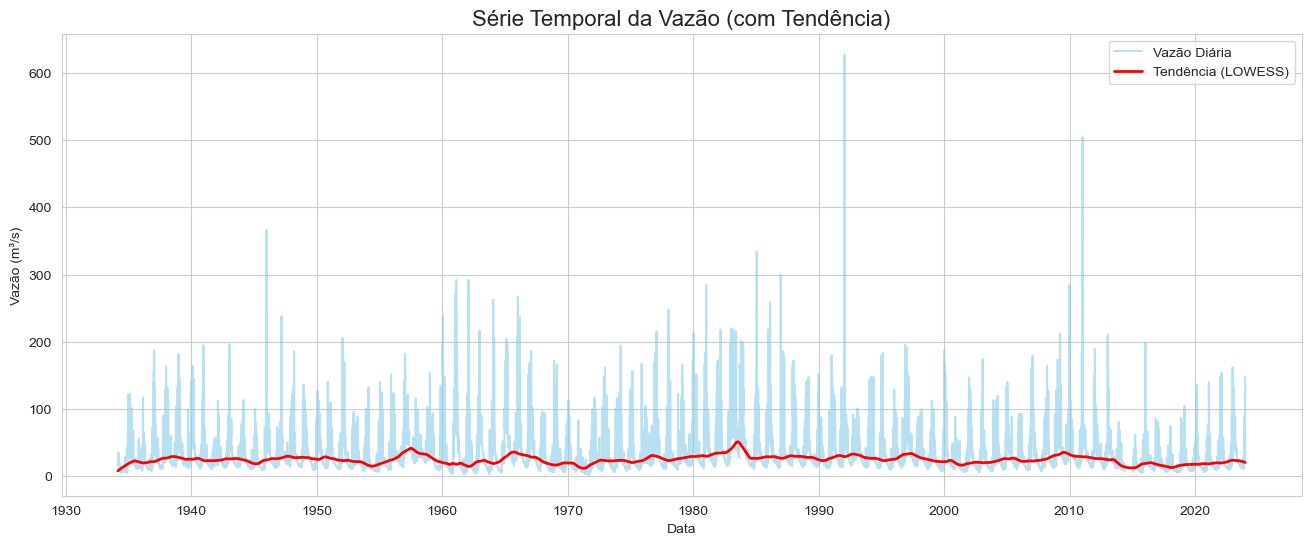

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\191792689.py:138: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




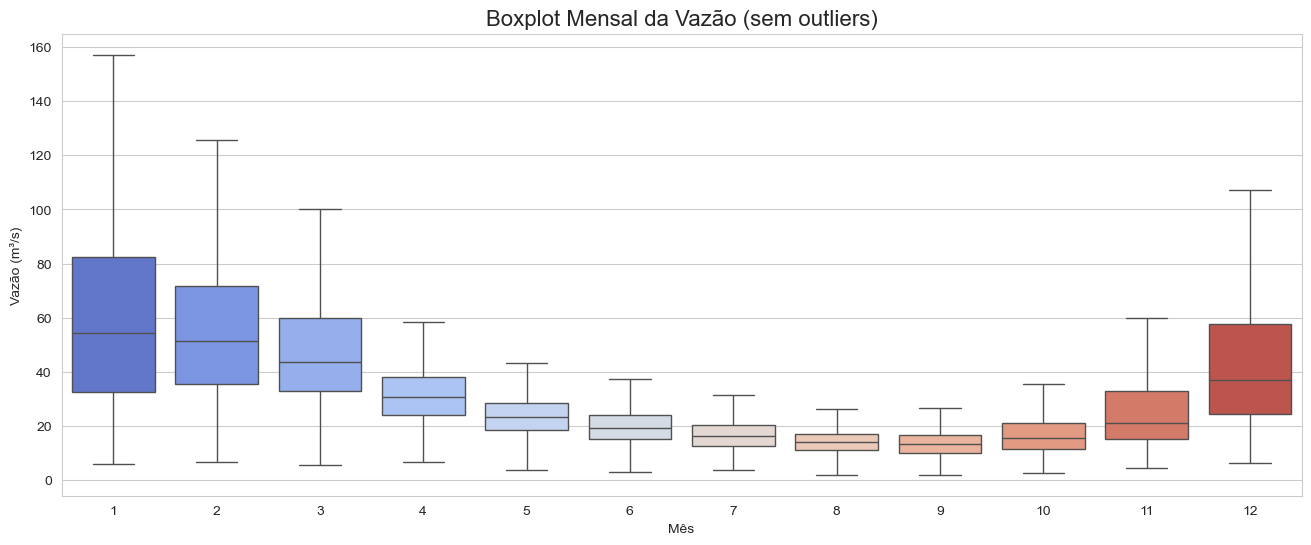

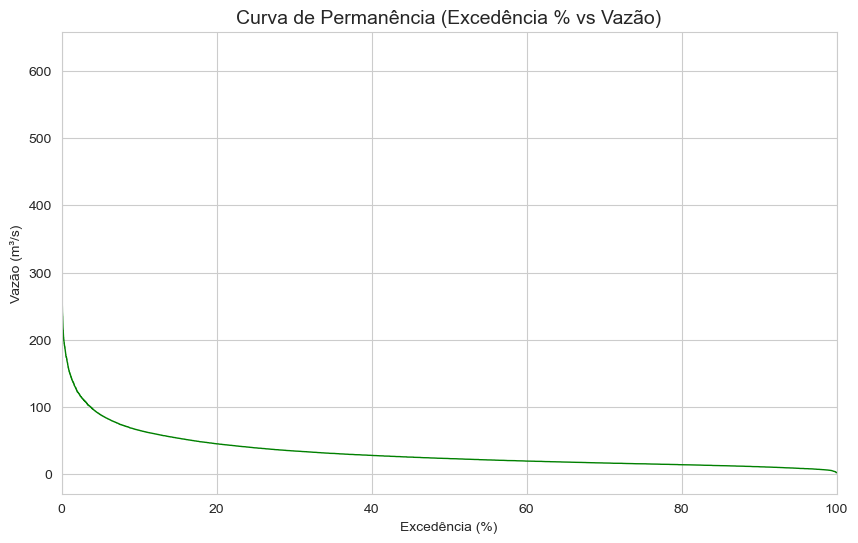

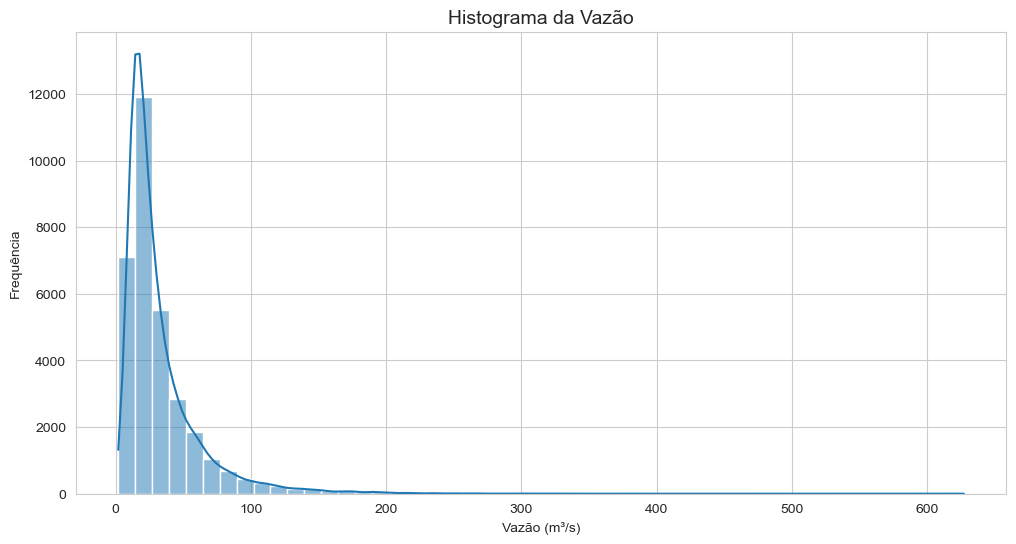

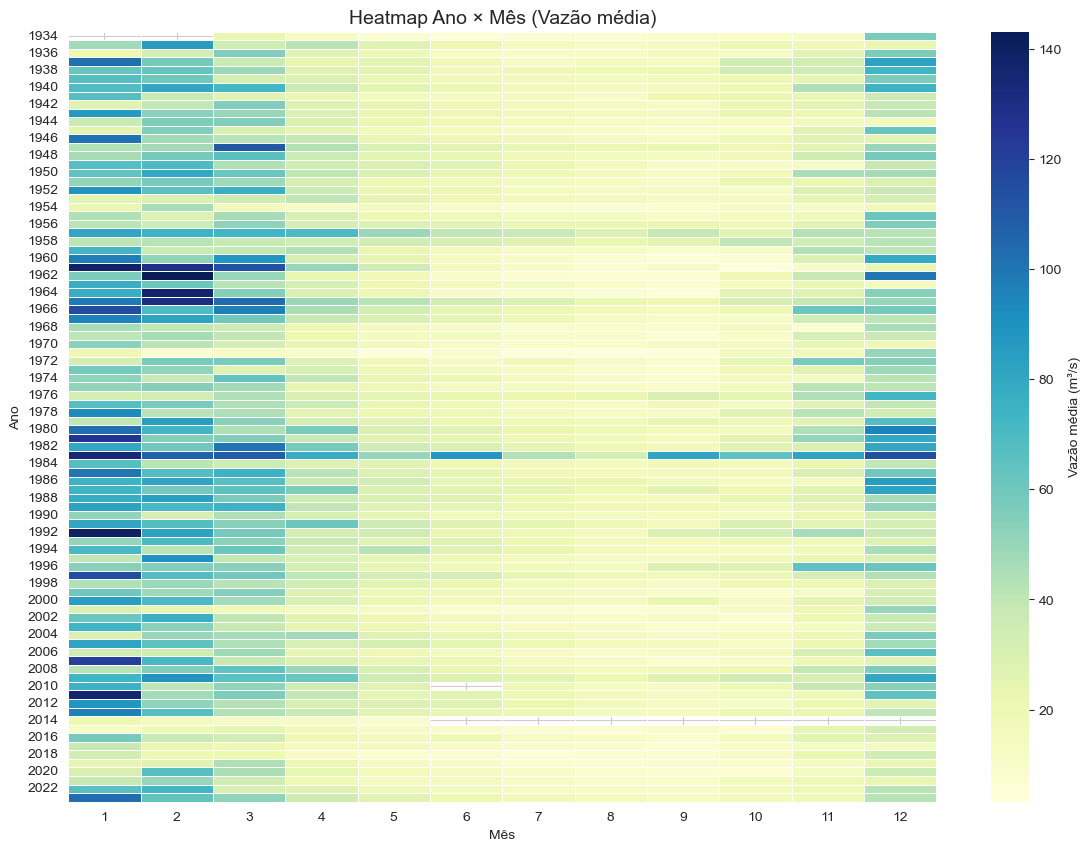

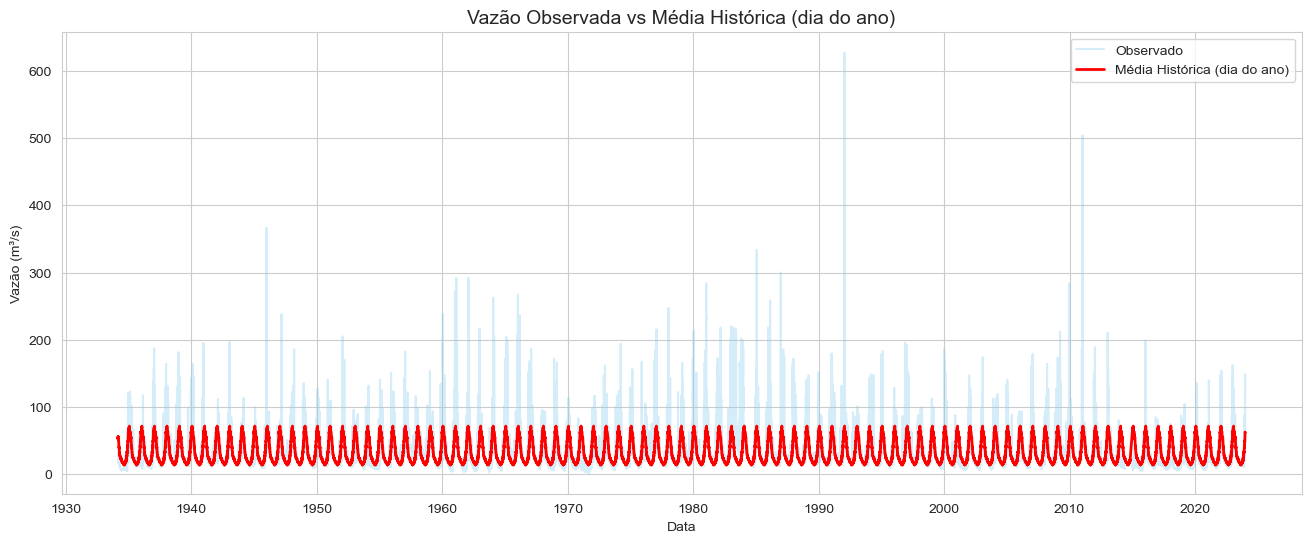

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\191792689.py:192: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




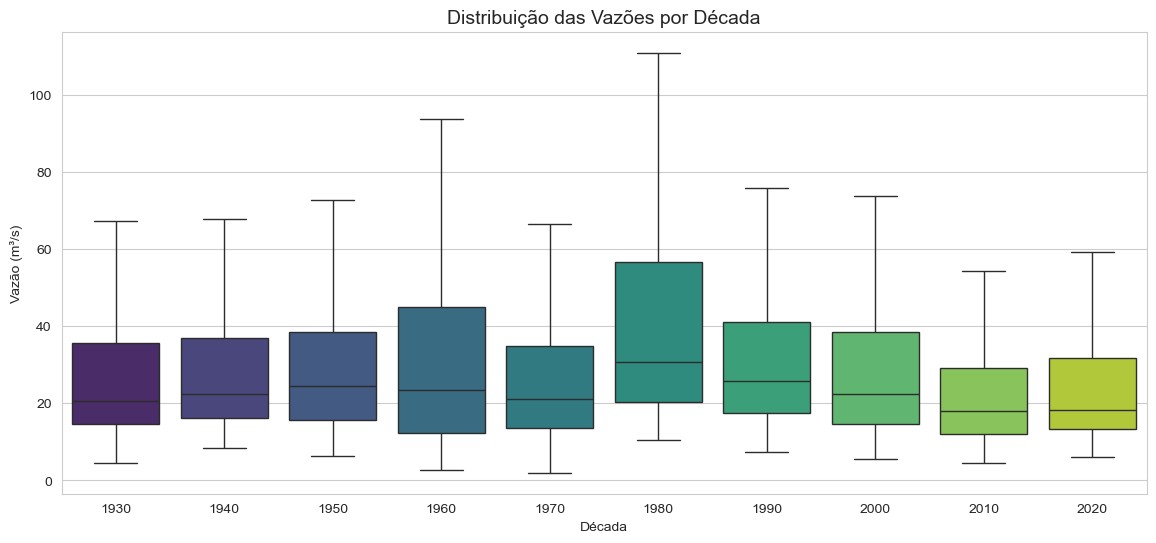

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\191792689.py:201: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




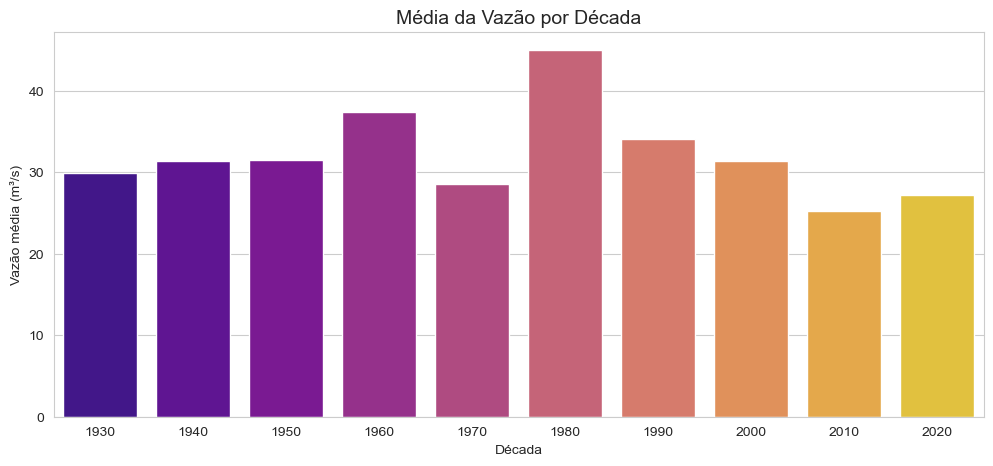

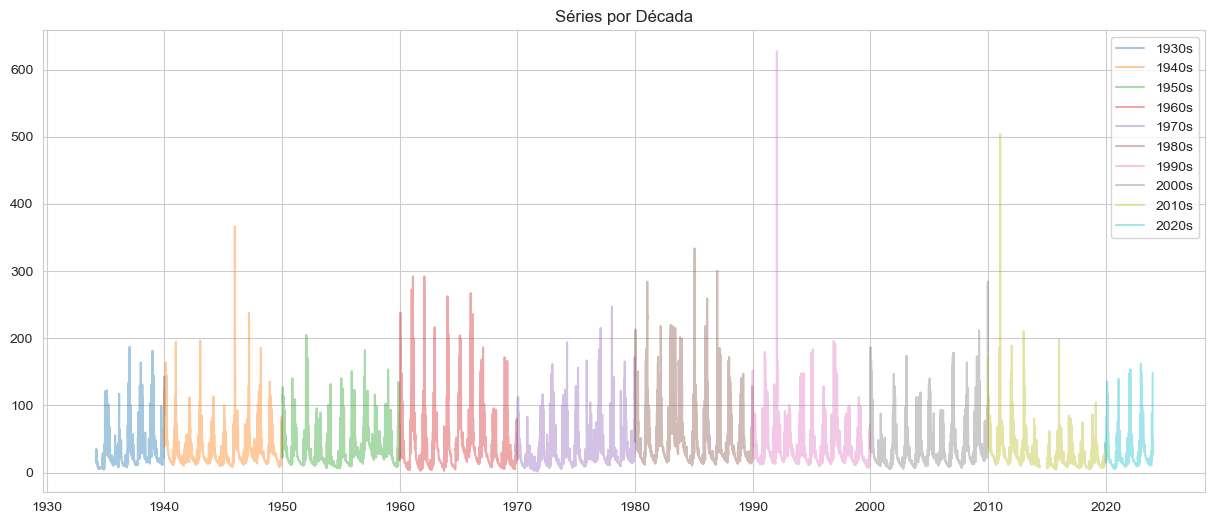

=== Índices hidrológicos ===
Q95 (cheia - 95th): 88.485 m³/s
Q50 (mediana): 23.044 m³/s
Q7  (mín. móvel 7 dias): 2.024 m³/s
Q5  (seca - 5th): 8.577 m³/s


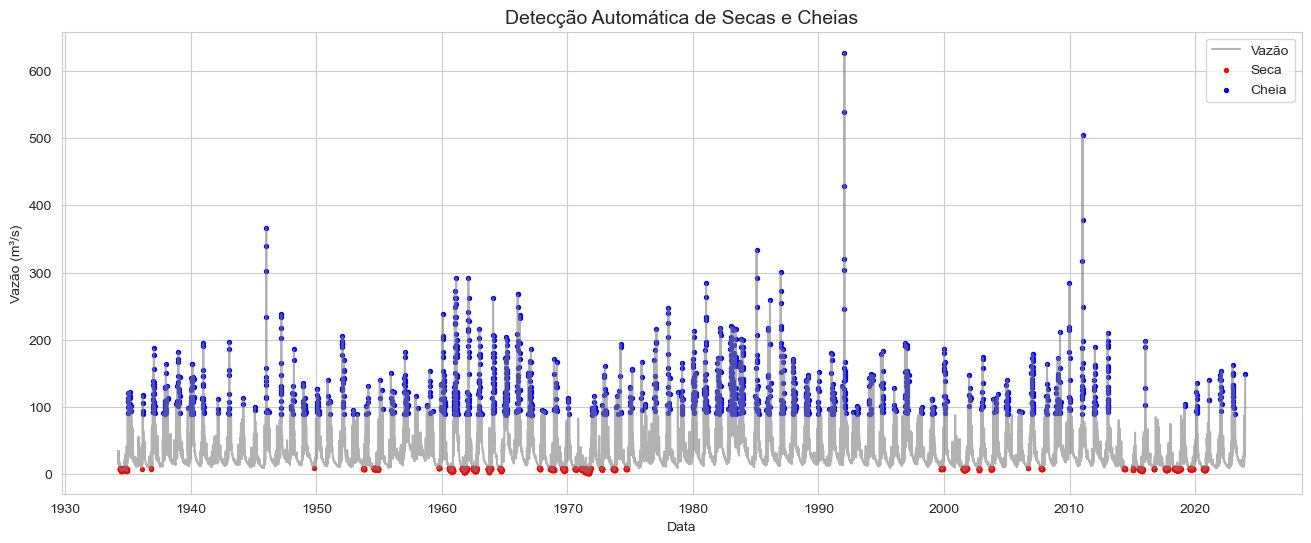

15:04:59 - cmdstanpy - INFO - Chain [1] start processing
15:05:57 - cmdstanpy - INFO - Chain [1] done processing


Previsão salva: Vazao_Prevista_Prophet_2030.csv


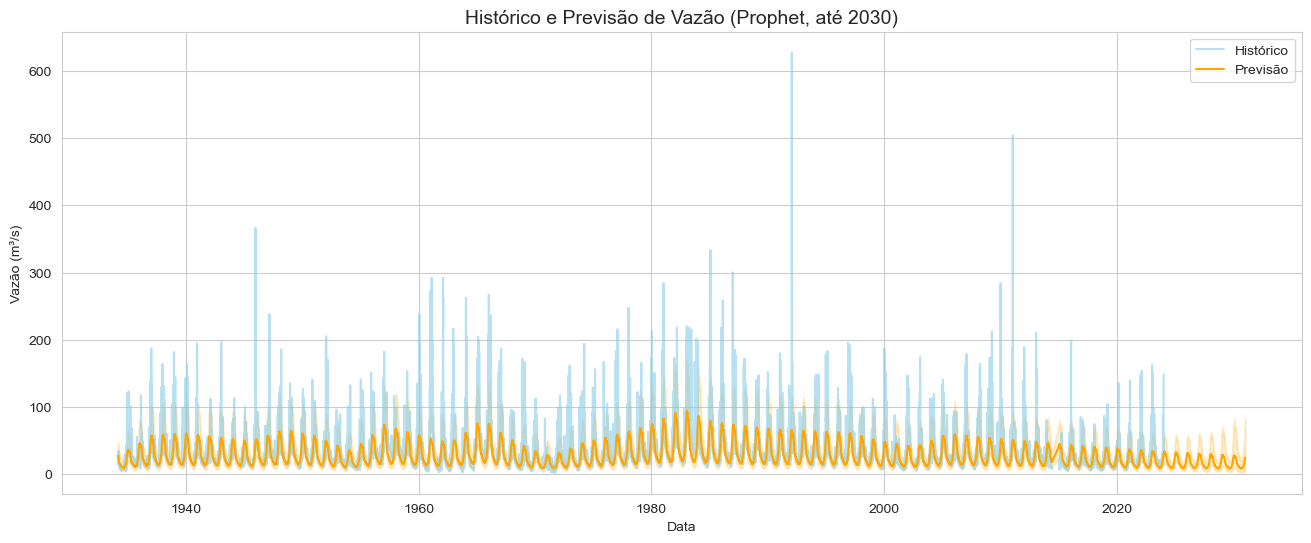

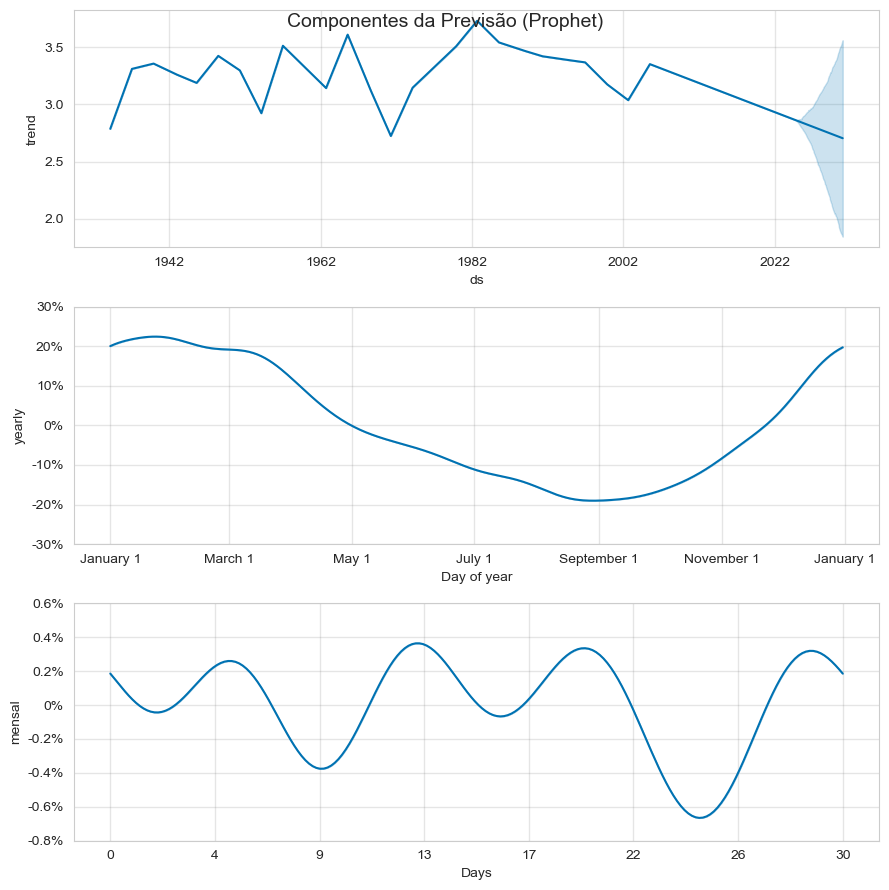

Agregados mensais e anuais exportados.


In [13]:
# =========================
# PIPELINE HIDROLÓGICO COMPLETO (rodar em 1 célula)
# =========================
# Ajuste apenas o caminho do arquivo abaixo se necessário:
arquivo = "61078000_Vazoes.csv"   # <-- coloque caminho completo se o arquivo não estiver na pasta do notebook
ano_fim_previsao = 2030
epsilon_log = 1e-6  # pequeno valor para estabilidade no log1p

# -------------------------
# Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (14,6)})

# -------------------------
# 0) Verificar existência do arquivo
# -------------------------
if not os.path.exists(arquivo):
    raise FileNotFoundError(f"Arquivo não encontrado: {arquivo}")

# -------------------------
# 1) Encontrar linha de cabeçalho da tabela (automático)
# -------------------------
def encontrar_linha_tabela(path):
    with open(path, 'r', encoding='latin1') as f:
        for i, linha in enumerate(f):
            if linha.startswith("EstacaoCodigo"):
                return i
    return None

linha_tabela = encontrar_linha_tabela(arquivo)
if linha_tabela is None:
    linha_tabela = 15  # fallback
print(f"Linha da tabela detectada (0-index): {linha_tabela}")

# -------------------------
# 2) Ler CSV (sep=';') de forma robusta
# -------------------------
df_raw = pd.read_csv(
    arquivo,
    sep=';',
    encoding='latin1',
    engine='python',
    skiprows=linha_tabela,
    decimal=',',
    skip_blank_lines=True
)

# Normalizar nomes de colunas
df_raw.columns = df_raw.columns.str.strip()

# Identificar coluna de Data e colunas Vazao01..Vazao31 (tolerante)
id_col_candidates = [c for c in df_raw.columns if 'data' in c.lower()]
if len(id_col_candidates) == 0:
    raise KeyError("Não foi possível encontrar coluna de Data no CSV. Verifique o cabeçalho.")
id_col = id_col_candidates[0]

vaz_cols = [c for c in df_raw.columns if c.lower().startswith('vazao') and 'status' not in c.lower()]
if len(vaz_cols) == 0:
    raise KeyError("Não encontrou colunas Vazao01..Vazao31 no CSV lido.")

print(f"Coluna Data detectada: {id_col}")
print(f"{len(vaz_cols)} colunas de vazão detectadas (ex.: {vaz_cols[:3]})")

# -------------------------
# 3) Transformar mensal -> diário (formato longo)
# -------------------------
df_long = df_raw.melt(
    id_vars=[id_col],
    value_vars=vaz_cols,
    var_name='DiaCol',
    value_name='Vazao'
)

# Extrair dia numérico da string 'Vazao01' -> 1
df_long['Dia'] = df_long['DiaCol'].str.extract('(\d+)').astype(float).astype('Int64')

# Converter coluna de mês (Data) no formato DD/MM/YYYY — robusto
df_long[id_col] = df_long[id_col].astype(str).str.strip()
df_long['DataMes'] = pd.to_datetime(df_long[id_col], format='%d/%m/%Y', dayfirst=True, errors='coerce')

# Função segura para criar DataCompleta (filtra dias inválidos como 31/02)
def criar_data_segura(row):
    if pd.isna(row['DataMes']) or pd.isna(row['Dia']):
        return pd.NaT
    ano = int(row['DataMes'].year)
    mes = int(row['DataMes'].month)
    dia = int(row['Dia'])
    ultimo_dia = pd.Period(f"{ano}-{mes:02d}", freq="M").days_in_month
    if 1 <= dia <= ultimo_dia:
        return pd.Timestamp(year=ano, month=mes, day=dia)
    else:
        return pd.NaT

df_long['DataCompleta'] = df_long.apply(criar_data_segura, axis=1)
df_long = df_long.dropna(subset=['DataCompleta']).reset_index(drop=True)

# Converter Vazao para float (garantir . decimal)
df_long['Vazao'] = pd.to_numeric(df_long['Vazao'].astype(str).str.replace(',', '.'), errors='coerce')

# Criar Ano, Mes e ordenar
df_long['Ano'] = df_long['DataCompleta'].dt.year
df_long['Mes'] = df_long['DataCompleta'].dt.month
df_long = df_long.sort_values('DataCompleta').reset_index(drop=True)

# Exportar CSV diário limpo
df_long.to_csv("Vazao_Diaria_ANA_Limpa.csv", index=False, encoding='utf-8')
print("CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv")

# -------------------------
# 4) Funções gráficas e análises
# -------------------------
def grafico_serie_temporal(df):
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], label='Vazão Diária', color='skyblue', alpha=0.6)
    # LOWESS para tendência (frac ajustável)
    x = np.arange(len(df))
    y = df['Vazao'].fillna(method='ffill').fillna(method='bfill').values
    low = lowess(y, x, frac=0.02, return_sorted=False)
    plt.plot(df['DataCompleta'], low, label='Tendência (LOWESS)', color='red', linewidth=2)
    plt.title('Série Temporal da Vazão (com Tendência)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

def grafico_boxplot_mensal(df):
    plt.figure(figsize=(16,6))
    sns.boxplot(x='Mes', y='Vazao', data=df, showfliers=False, color=None, palette='coolwarm')
    plt.title('Boxplot Mensal da Vazão (sem outliers)', fontsize=16)
    plt.xlabel('Mês')
    plt.ylabel('Vazão (m³/s)')
    plt.show()

def curva_permanencia(df):
    serie = df['Vazao'].dropna().sort_values(ascending=False).reset_index(drop=True)
    prob = np.arange(1, len(serie)+1) / len(serie) * 100
    plt.figure(figsize=(10,6))
    plt.plot(prob, serie, color='green', linewidth=1)
    plt.gca().invert_xaxis()
    plt.xlim(0,100)
    plt.title('Curva de Permanência (Excedência % vs Vazão)', fontsize=14)
    plt.xlabel('Excedência (%)')
    plt.ylabel('Vazão (m³/s)')
    plt.grid(True)
    plt.show()

def histograma_vazao(df):
    plt.figure(figsize=(12,6))
    sns.histplot(df['Vazao'].dropna(), bins=50, kde=True)
    plt.title('Histograma da Vazão', fontsize=14)
    plt.xlabel('Vazão (m³/s)')
    plt.ylabel('Frequência')
    plt.show()

def heatmap_ano_mes(df):
    pivot = df.pivot_table(index='Ano', columns='Mes', values='Vazao', aggfunc='mean')
    plt.figure(figsize=(14,10))
    sns.heatmap(pivot, cmap='YlGnBu', cbar_kws={'label':'Vazão média (m³/s)'}, annot=False, linewidths=0.4)
    plt.title('Heatmap Ano × Mês (Vazão média)', fontsize=14)
    plt.xlabel('Mês')
    plt.ylabel('Ano')
    plt.show()

def comparacao_media_historica(df):
    temp = df.copy()
    temp['DiaAno'] = temp['DataCompleta'].dt.dayofyear
    media_diaria = temp.groupby('DiaAno')['Vazao'].mean()
    media_full = temp['DiaAno'].map(media_diaria)
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], color='skyblue', alpha=0.35, label='Observado')
    plt.plot(df['DataCompleta'], media_full, color='red', linewidth=2, label='Média Histórica (dia do ano)')
    plt.title('Vazão Observada vs Média Histórica (dia do ano)', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    plt.show()

def grafico_por_decada(df):
    df2 = df.copy()
    df2['Decada'] = (df2['Ano'] // 10) * 10
    plt.figure(figsize=(14,6))
    sns.boxplot(x='Decada', y='Vazao', data=df2, showfliers=False, palette='viridis')
    plt.title('Distribuição das Vazões por Década', fontsize=14)
    plt.xlabel('Década')
    plt.ylabel('Vazão (m³/s)')
    plt.show()

    # média por década
    media_dec = df2.groupby('Decada')['Vazao'].mean().reset_index()
    plt.figure(figsize=(12,5))
    sns.barplot(x='Decada', y='Vazao', data=media_dec, palette='plasma')
    plt.title('Média da Vazão por Década', fontsize=14)
    plt.xlabel('Década')
    plt.ylabel('Vazão média (m³/s)')
    plt.show()

    # séries por década
    plt.figure(figsize=(15,6))
    for dec, grp in df2.groupby('Decada'):
        plt.plot(grp['DataCompleta'], grp['Vazao'], alpha=0.4, label=f'{dec}s')
    plt.title('Séries por Década')
    plt.legend()
    plt.show()

# -------------------------
# 5) Índices hidrológicos clássicos
# -------------------------
def calcular_indices(df):
    s = df['Vazao'].dropna()
    Q95 = np.percentile(s, 95)   # cheias altas
    Q50 = np.percentile(s, 50)   # mediana
    Q5  = np.percentile(s, 5)    # secas baixas
    rolling7 = s.rolling(7, min_periods=1).mean()
    Q7 = rolling7.min()
    print("=== Índices hidrológicos ===")
    print(f"Q95 (cheia - 95th): {Q95:.3f} m³/s")
    print(f"Q50 (mediana): {Q50:.3f} m³/s")
    print(f"Q7  (mín. móvel 7 dias): {Q7:.3f} m³/s")
    print(f"Q5  (seca - 5th): {Q5:.3f} m³/s")
    return {'Q95':Q95, 'Q50':Q50, 'Q7':Q7, 'Q5':Q5}

# -------------------------
# 6) Detecção automática de secas e cheias
# -------------------------
def detectar_secas_cheias(df, indices):
    dfc = df.copy()
    dfc['Evento'] = 'Normal'
    dfc.loc[dfc['Vazao'] <= indices['Q5'], 'Evento'] = 'Seca'
    dfc.loc[dfc['Vazao'] >= indices['Q95'], 'Evento'] = 'Cheia'

    plt.figure(figsize=(16,6))
    plt.plot(dfc['DataCompleta'], dfc['Vazao'], color='gray', alpha=0.6, label='Vazão')
    if dfc[dfc['Evento']=='Seca'].shape[0] > 0:
        plt.scatter(dfc[dfc['Evento']=='Seca']['DataCompleta'], dfc[dfc['Evento']=='Seca']['Vazao'],
                    color='red', s=8, label='Seca')
    if dfc[dfc['Evento']=='Cheia'].shape[0] > 0:
        plt.scatter(dfc[dfc['Evento']=='Cheia']['DataCompleta'], dfc[dfc['Evento']=='Cheia']['Vazao'],
                    color='blue', s=8, label='Cheia')
    plt.title('Detecção Automática de Secas e Cheias', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    plt.show()
    return dfc

# -------------------------
# 7) Previsão com Prophet (log1p + multiplicative seasonality + conversão segura)
# -------------------------
def previsao_prophet(df, ano_fim=ano_fim_previsao):
    # preparar df para prophet
    dfp = df[['DataCompleta','Vazao']].rename(columns={'DataCompleta':'ds','Vazao':'y'}).dropna().copy()
    # garantir >=0 e estabilidade
    dfp['y'] = dfp['y'].clip(lower=0) + epsilon_log
    # transformar
    dfp['y_log'] = np.log1p(dfp['y'])
    dfp_prophet = dfp[['ds','y_log']].rename(columns={'y_log':'y'})

    # configurar modelo
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    # adicionar sazonalidade mensal explícita (opcionalmente melhora ajuste)
    m.add_seasonality(name='mensal', period=30.5, fourier_order=5)
    m.fit(dfp_prophet)

    dias = (pd.to_datetime(f"{ano_fim}-12-31") - dfp['ds'].max()).days
    future = m.make_future_dataframe(periods=dias)
    forecast = m.predict(future)

    # converter de volta do log e garantir >=0
    forecast['yhat_orig'] = np.expm1(forecast['yhat']).clip(lower=0)
    forecast['yhat_lower_orig'] = np.expm1(forecast['yhat_lower']).clip(lower=0)
    forecast['yhat_upper_orig'] = np.expm1(forecast['yhat_upper']).clip(lower=0)

    # salvar CSV previsão
    out = forecast[['ds','yhat_orig','yhat_lower_orig','yhat_upper_orig']].rename(columns={
        'ds':'Data',
        'yhat_orig':'Vazao_Prevista',
        'yhat_lower_orig':'Vazao_Prevista_Lower',
        'yhat_upper_orig':'Vazao_Prevista_Upper'
    })
    out.to_csv("Vazao_Prevista_Prophet_2030.csv", index=False, encoding='utf-8')
    print("Previsão salva: Vazao_Prevista_Prophet_2030.csv")
    return m, forecast, out

def grafico_previsao(m, forecast, df):
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], label='Histórico', color='skyblue', alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat_orig'], label='Previsão', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower_orig'], forecast['yhat_upper_orig'], color='orange', alpha=0.2)
    plt.title(f'Histórico e Previsão de Vazão (Prophet, até {ano_fim_previsao})', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    plt.show()

    # componentes (note: componentes modelados na escala log; exibir mesmo assim é útil)
    m.plot_components(forecast)
    plt.suptitle('Componentes da Previsão (Prophet)', fontsize=14)
    plt.show()

# -------------------------
# 8) Executar sequência (gráficos, índices, eventos, previsão)
# -------------------------
# Exploratórios
grafico_serie_temporal(df_long)
grafico_boxplot_mensal(df_long)
curva_permanencia(df_long)
histograma_vazao(df_long)
heatmap_ano_mes(df_long)
comparacao_media_historica(df_long)
grafico_por_decada(df_long)

# Índices e eventos
indices = calcular_indices(df_long)
df_evt = detectar_secas_cheias(df_long, indices)

# Previsão
modelo_prophet, forecast_prophet, out_prev = previsao_prophet(df_long, ano_fim=ano_fim_previsao)
grafico_previsao(modelo_prophet, forecast_prophet, df_long)

# -------------------------
# 9) Exportar agregados mensais e anuais
# -------------------------
df_mes = df_long.groupby(df_long['DataCompleta'].dt.to_period('M'))['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_mes['DataMes'] = df_mes['DataCompleta'].dt.to_timestamp()
df_mes.rename(columns={'mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)
df_mes[['DataMes','Vazao_Media','Vazao_Max','Vazao_Min','Vazao_Total']].to_csv("Vazao_Mensal_Agregada.csv", index=False, encoding='utf-8')

df_ano = df_long.groupby(df_long['DataCompleta'].dt.year)['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_ano.rename(columns={'year':'Ano','mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)
df_ano.to_csv("Vazao_Anual_Agregada.csv", index=False, encoding='utf-8')

print("Agregados mensais e anuais exportados.")


Linha da tabela detectada (0-index): 15
Coluna Data detectada: Data
31 colunas de vazão detectadas (ex.: ['Vazao01', 'Vazao02', 'Vazao03'])
CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv


C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\158833474.py:119: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



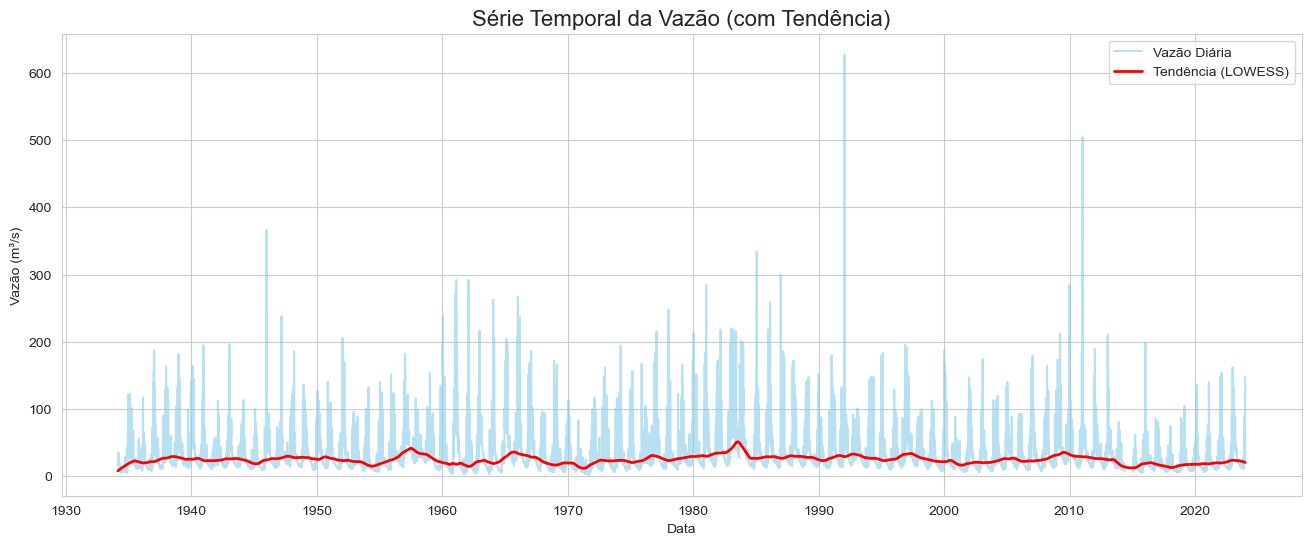

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\158833474.py:132: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




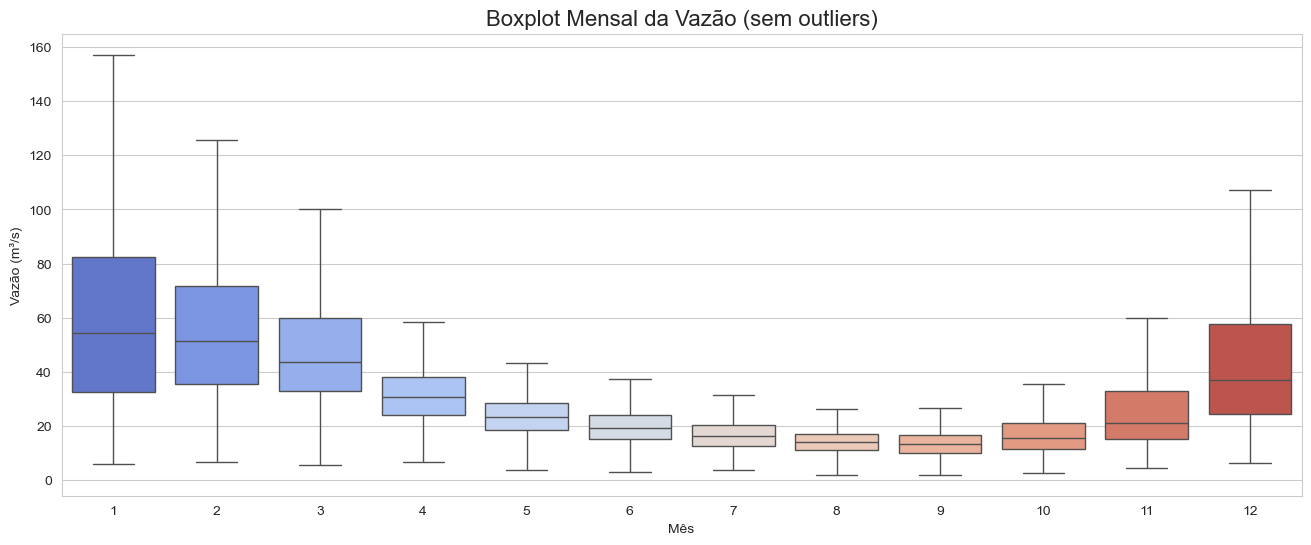

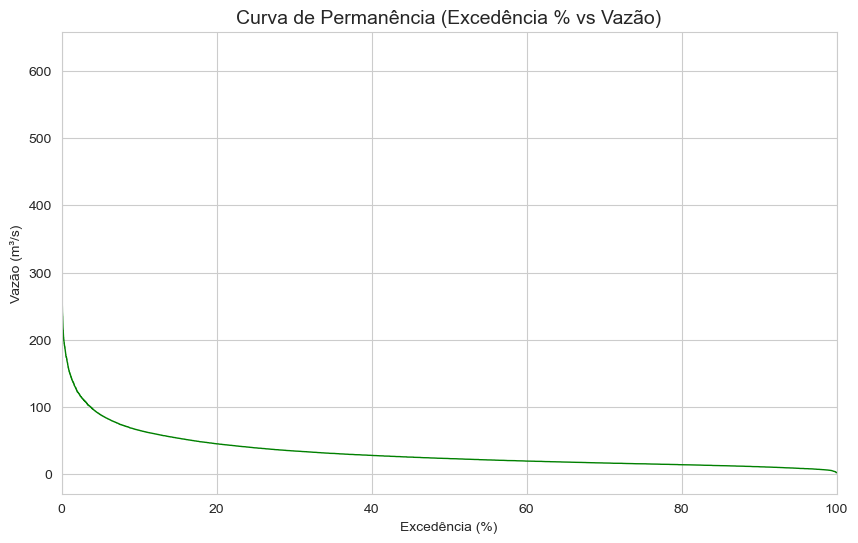

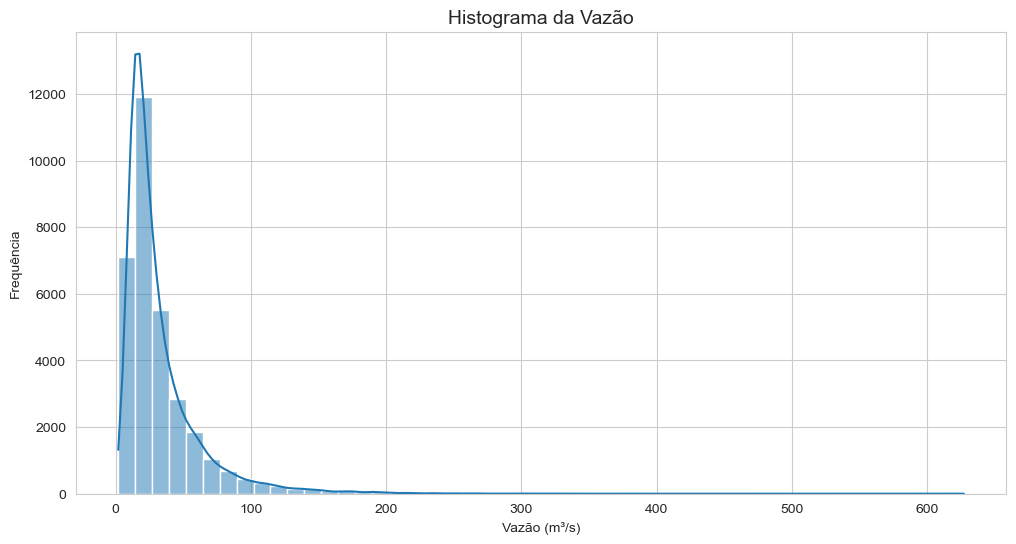

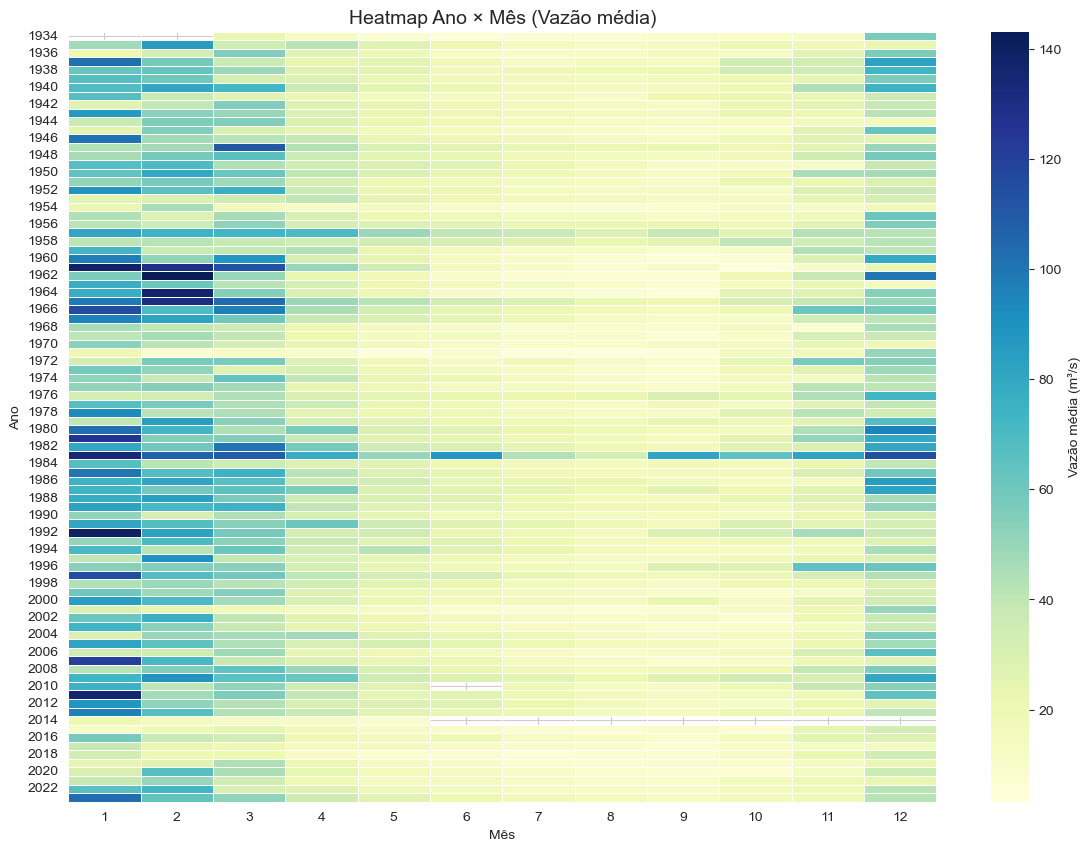

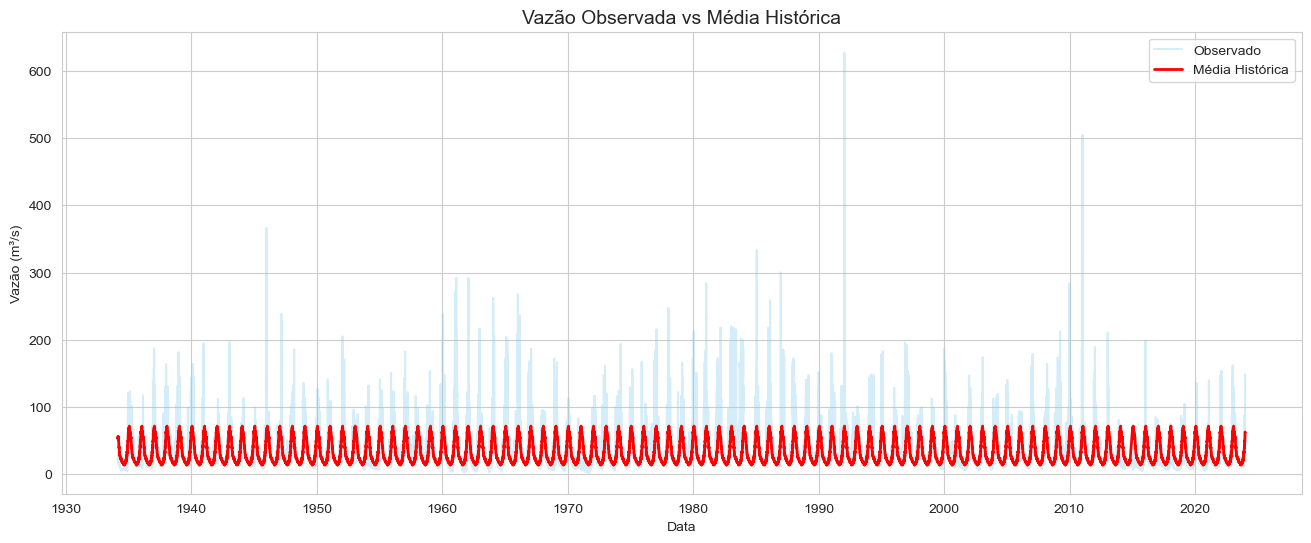

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\158833474.py:191: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




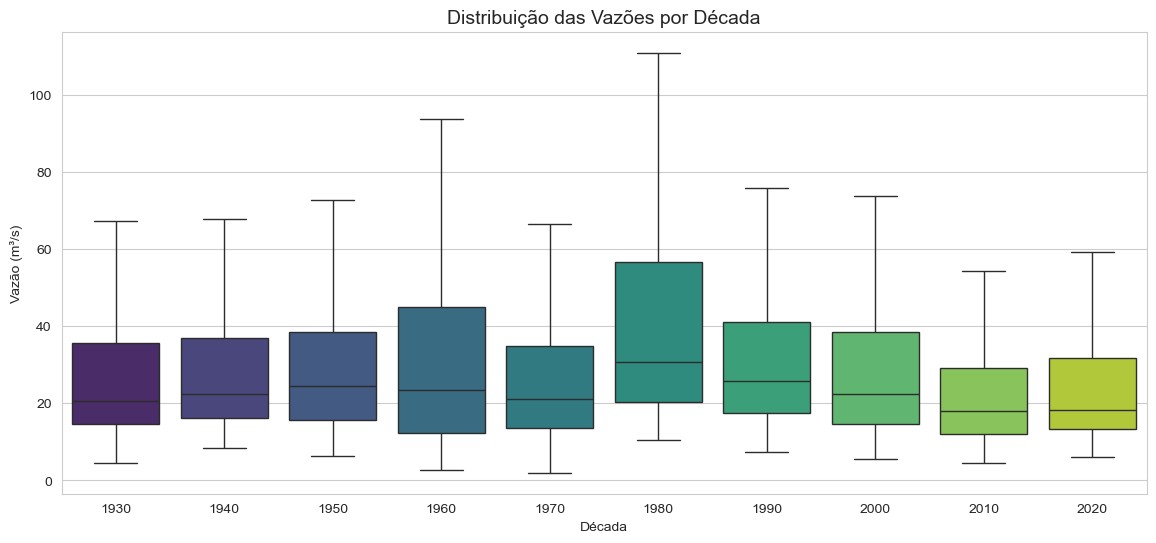

C:\Users\Rafae\AppData\Local\Temp\ipykernel_12192\158833474.py:200: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




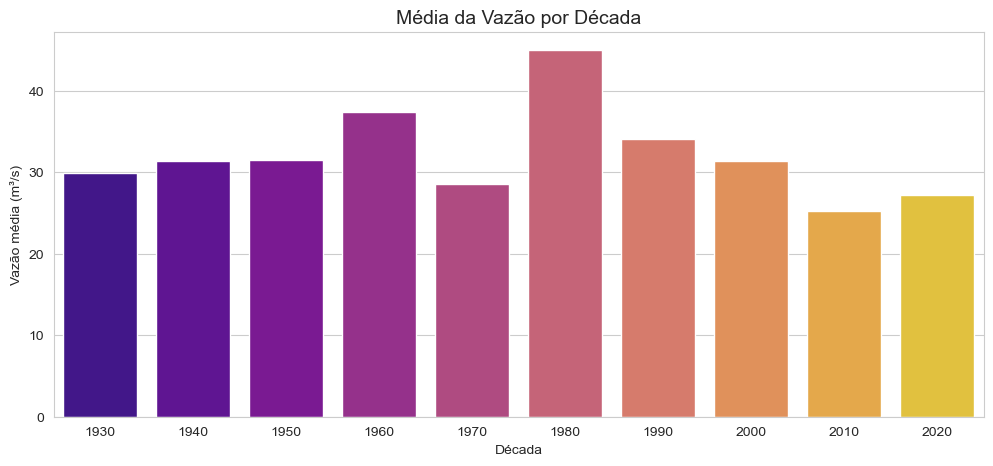

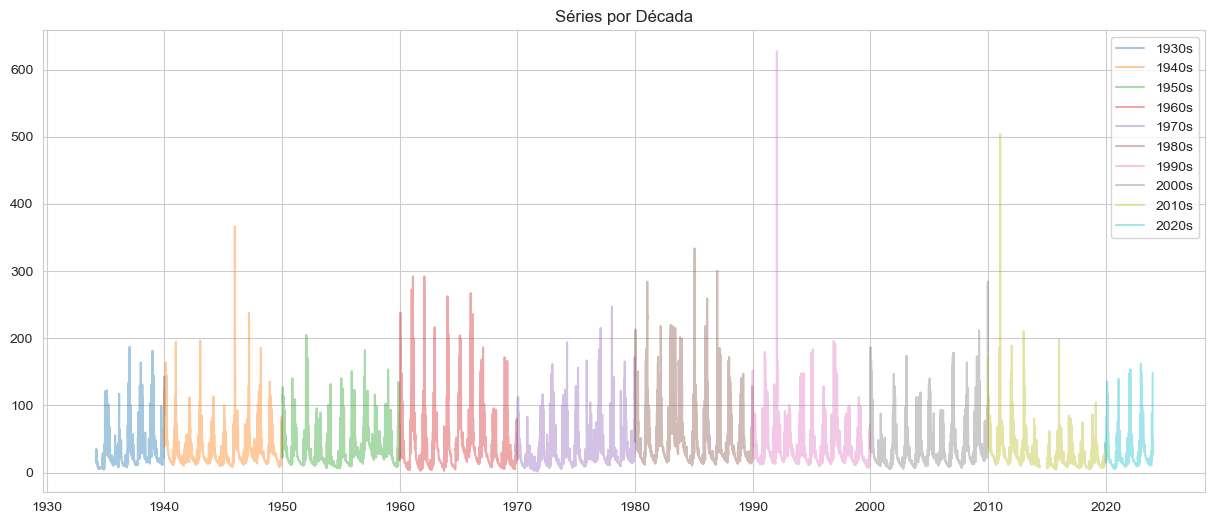

=== Índices hidrológicos ===
Q95 (cheia - 95th): 88.485 m³/s
Q50 (mediana): 23.044 m³/s
Q7  (mín. móvel 7 dias): 2.024 m³/s
Q5  (seca - 5th): 8.577 m³/s


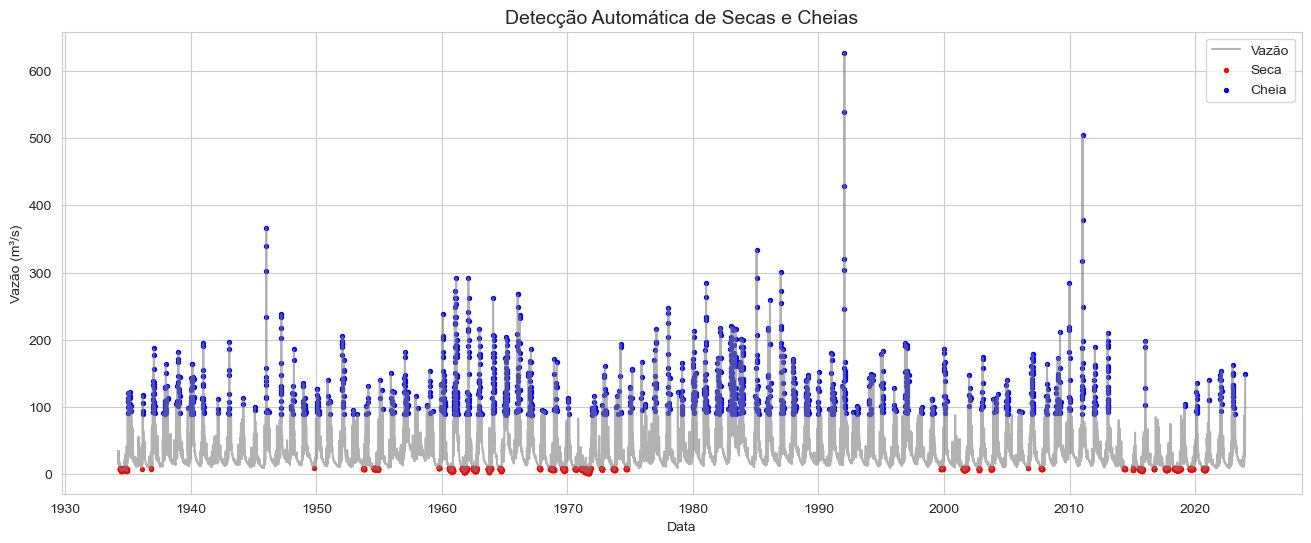

15:41:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:03 - cmdstanpy - INFO - Chain [1] done processing


Previsão salva: Vazao_Prevista_Prophet_2030.csv


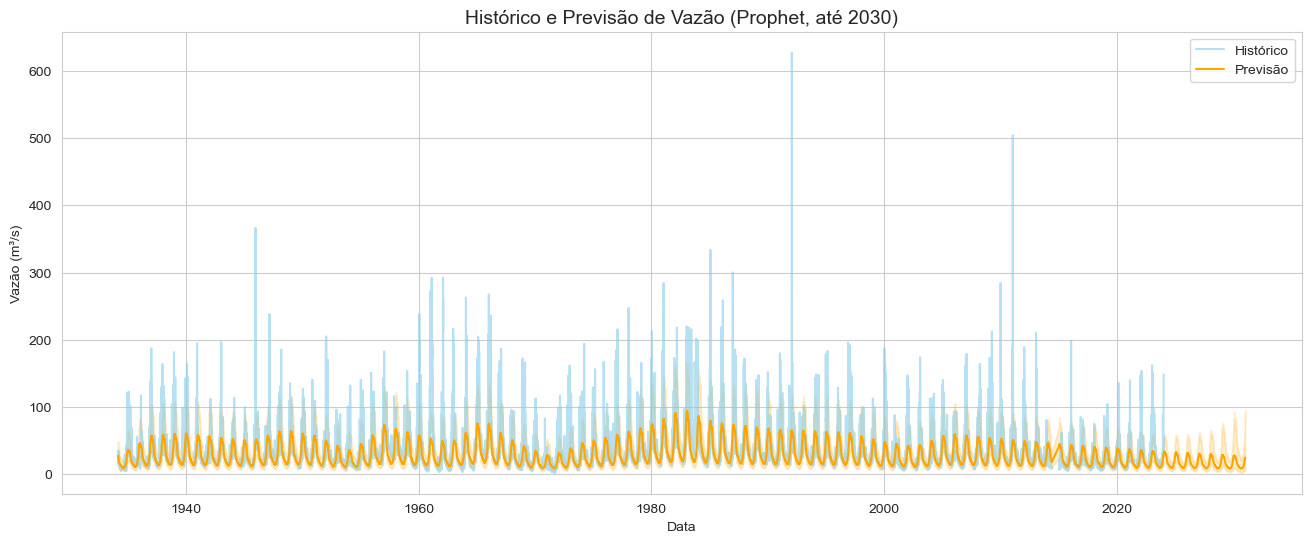

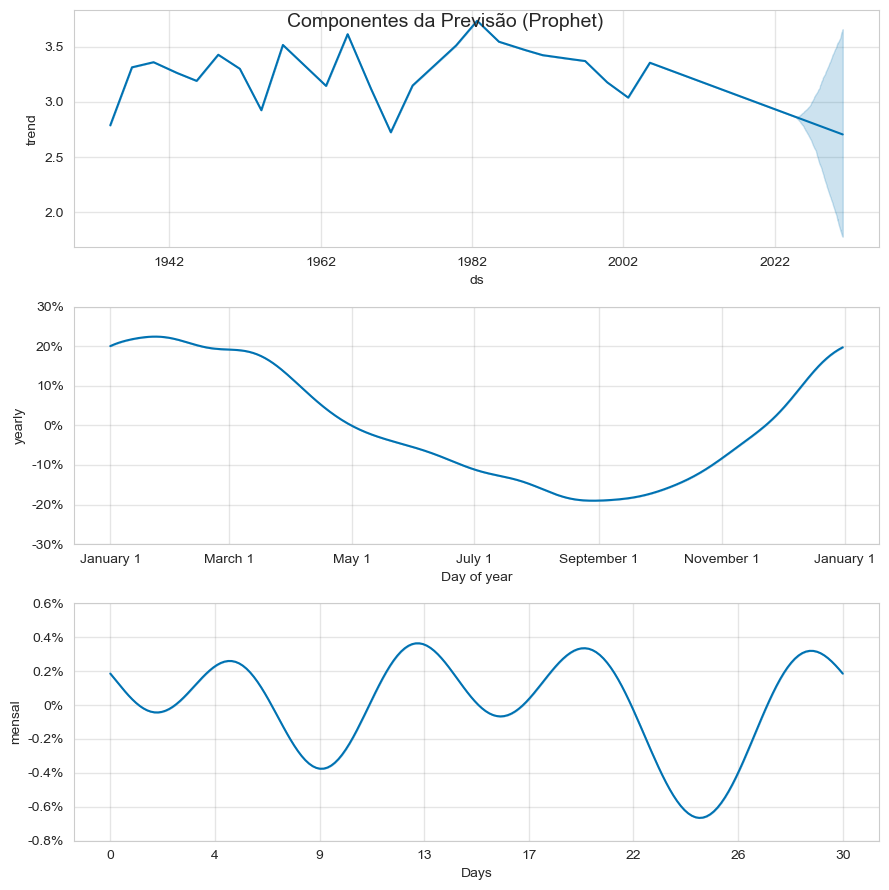

In [ ]:
# =========================
# PIPELINE HIDROLÓGICO COMPLETO + EXPORTAÇÃO DE GRÁFICOS
# =========================
# Ajuste apenas o caminho do arquivo abaixo se necessário:
arquivo = "61078000_Vazoes.csv"   # <-- caminho do CSV
ano_fim_previsao = 2030
epsilon_log = 1e-6  # pequeno valor para estabilidade no log1p
pasta_graficos = "Graficos"  # pasta para salvar os gráficos

# -------------------------
# Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (14,6)})

# Criar pasta de gráficos se não existir
os.makedirs(pasta_graficos, exist_ok=True)

# -------------------------
# 0) Verificar arquivo
# -------------------------
if not os.path.exists(arquivo):
    raise FileNotFoundError(f"Arquivo não encontrado: {arquivo}")

# -------------------------
# 1) Encontrar linha de cabeçalho
# -------------------------
def encontrar_linha_tabela(path):
    with open(path, 'r', encoding='latin1') as f:
        for i, linha in enumerate(f):
            if linha.startswith("EstacaoCodigo"):
                return i
    return None

linha_tabela = encontrar_linha_tabela(arquivo)
if linha_tabela is None:
    linha_tabela = 15
print(f"Linha da tabela detectada (0-index): {linha_tabela}")

# -------------------------
# 2) Ler CSV
# -------------------------
df_raw = pd.read_csv(
    arquivo,
    sep=';',
    encoding='latin1',
    engine='python',
    skiprows=linha_tabela,
    decimal=',',
    skip_blank_lines=True
)
df_raw.columns = df_raw.columns.str.strip()
id_col_candidates = [c for c in df_raw.columns if 'data' in c.lower()]
if len(id_col_candidates) == 0:
    raise KeyError("Não foi possível encontrar coluna de Data no CSV.")
id_col = id_col_candidates[0]
vaz_cols = [c for c in df_raw.columns if c.lower().startswith('vazao') and 'status' not in c.lower()]
if len(vaz_cols) == 0:
    raise KeyError("Não encontrou colunas Vazao01..Vazao31 no CSV lido.")
print(f"Coluna Data detectada: {id_col}")
print(f"{len(vaz_cols)} colunas de vazão detectadas (ex.: {vaz_cols[:3]})")

# -------------------------
# 3) Transformar mensal -> diário
# -------------------------
df_long = df_raw.melt(
    id_vars=[id_col],
    value_vars=vaz_cols,
    var_name='DiaCol',
    value_name='Vazao'
)
df_long['Dia'] = df_long['DiaCol'].str.extract('(\d+)').astype(float).astype('Int64')
df_long[id_col] = df_long[id_col].astype(str).str.strip()
df_long['DataMes'] = pd.to_datetime(df_long[id_col], format='%d/%m/%Y', dayfirst=True, errors='coerce')

def criar_data_segura(row):
    if pd.isna(row['DataMes']) or pd.isna(row['Dia']):
        return pd.NaT
    ano = int(row['DataMes'].year)
    mes = int(row['DataMes'].month)
    dia = int(row['Dia'])
    ultimo_dia = pd.Period(f"{ano}-{mes:02d}", freq="M").days_in_month
    if 1 <= dia <= ultimo_dia:
        return pd.Timestamp(year=ano, month=mes, day=dia)
    else:
        return pd.NaT

df_long['DataCompleta'] = df_long.apply(criar_data_segura, axis=1)
df_long = df_long.dropna(subset=['DataCompleta']).reset_index(drop=True)
df_long['Vazao'] = pd.to_numeric(df_long['Vazao'].astype(str).str.replace(',', '.'), errors='coerce')
df_long['Ano'] = df_long['DataCompleta'].dt.year
df_long['Mes'] = df_long['DataCompleta'].dt.month
df_long = df_long.sort_values('DataCompleta').reset_index(drop=True)
df_long.to_csv("Vazao_Diaria_ANA_Limpa.csv", index=False, encoding='utf-8')
print("CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv")

# -------------------------
# Função utilitária para salvar figuras
# -------------------------
def salvar_figura(nome):
    plt.savefig(os.path.join(pasta_graficos, nome+".png"), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(pasta_graficos, nome+".pdf"), dpi=300, bbox_inches='tight')

# -------------------------
# 4) Funções gráficas
# -------------------------
def grafico_serie_temporal(df):
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], label='Vazão Diária', color='skyblue', alpha=0.6)
    x = np.arange(len(df))
    y = df['Vazao'].fillna(method='ffill').fillna(method='bfill').values
    low = lowess(y, x, frac=0.02, return_sorted=False)
    plt.plot(df['DataCompleta'], low, label='Tendência (LOWESS)', color='red', linewidth=2)
    plt.title('Série Temporal da Vazão (com Tendência)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    plt.grid(True)
    salvar_figura("SerieTemporal_Vazao")
    plt.show()

def grafico_boxplot_mensal(df):
    plt.figure(figsize=(16,6))
    sns.boxplot(x='Mes', y='Vazao', data=df, showfliers=False, palette='coolwarm')
    plt.title('Boxplot Mensal da Vazão (sem outliers)', fontsize=16)
    plt.xlabel('Mês')
    plt.ylabel('Vazão (m³/s)')
    salvar_figura("Boxplot_Mensal")
    plt.show()

def curva_permanencia(df):
    serie = df['Vazao'].dropna().sort_values(ascending=False).reset_index(drop=True)
    prob = np.arange(1, len(serie)+1) / len(serie) * 100
    plt.figure(figsize=(10,6))
    plt.plot(prob, serie, color='green', linewidth=1)
    plt.gca().invert_xaxis()
    plt.xlim(0,100)
    plt.title('Curva de Permanência (Excedência % vs Vazão)', fontsize=14)
    plt.xlabel('Excedência (%)')
    plt.ylabel('Vazão (m³/s)')
    plt.grid(True)
    salvar_figura("Curva_Permanencia")
    plt.show()

def histograma_vazao(df):
    plt.figure(figsize=(12,6))
    sns.histplot(df['Vazao'].dropna(), bins=50, kde=True)
    plt.title('Histograma da Vazão', fontsize=14)
    plt.xlabel('Vazão (m³/s)')
    plt.ylabel('Frequência')
    salvar_figura("Histograma_Vazao")
    plt.show()

def heatmap_ano_mes(df):
    pivot = df.pivot_table(index='Ano', columns='Mes', values='Vazao', aggfunc='mean')
    plt.figure(figsize=(14,10))
    sns.heatmap(pivot, cmap='YlGnBu', cbar_kws={'label':'Vazão média (m³/s)'}, annot=False, linewidths=0.4)
    plt.title('Heatmap Ano × Mês (Vazão média)', fontsize=14)
    plt.xlabel('Mês')
    plt.ylabel('Ano')
    salvar_figura("Heatmap_Ano_Mes")
    plt.show()

def comparacao_media_historica(df):
    temp = df.copy()
    temp['DiaAno'] = temp['DataCompleta'].dt.dayofyear
    media_diaria = temp.groupby('DiaAno')['Vazao'].mean()
    media_full = temp['DiaAno'].map(media_diaria)
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], color='skyblue', alpha=0.35, label='Observado')
    plt.plot(df['DataCompleta'], media_full, color='red', linewidth=2, label='Média Histórica')
    plt.title('Vazão Observada vs Média Histórica', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    salvar_figura("Comparacao_Media_Historica")
    plt.show()

def grafico_por_decada(df):
    df2 = df.copy()
    df2['Decada'] = (df2['Ano'] // 10) * 10
    plt.figure(figsize=(14,6))
    sns.boxplot(x='Decada', y='Vazao', data=df2, showfliers=False, palette='viridis')
    plt.title('Distribuição das Vazões por Década', fontsize=14)
    plt.xlabel('Década')
    plt.ylabel('Vazão (m³/s)')
    salvar_figura("Boxplot_Vazao_Decada")
    plt.show()

    media_dec = df2.groupby('Decada')['Vazao'].mean().reset_index()
    plt.figure(figsize=(12,5))
    sns.barplot(x='Decada', y='Vazao', data=media_dec, palette='plasma')
    plt.title('Média da Vazão por Década', fontsize=14)
    plt.xlabel('Década')
    plt.ylabel('Vazão média (m³/s)')
    salvar_figura("Media_Vazao_Decada")
    plt.show()

    plt.figure(figsize=(15,6))
    for dec, grp in df2.groupby('Decada'):
        plt.plot(grp['DataCompleta'], grp['Vazao'], alpha=0.4, label=f'{dec}s')
    plt.title('Séries por Década')
    plt.legend()
    salvar_figura("Series_Por_Decada")
    plt.show()

# -------------------------
# 5) Índices hidrológicos
# -------------------------
def calcular_indices(df):
    s = df['Vazao'].dropna()
    Q95 = np.percentile(s, 95)
    Q50 = np.percentile(s, 50)
    Q5  = np.percentile(s, 5)
    rolling7 = s.rolling(7, min_periods=1).mean()
    Q7 = rolling7.min()
    print("=== Índices hidrológicos ===")
    print(f"Q95 (cheia - 95th): {Q95:.3f} m³/s")
    print(f"Q50 (mediana): {Q50:.3f} m³/s")
    print(f"Q7  (mín. móvel 7 dias): {Q7:.3f} m³/s")
    print(f"Q5  (seca - 5th): {Q5:.3f} m³/s")
    return {'Q95':Q95, 'Q50':Q50, 'Q7':Q7, 'Q5':Q5}

# -------------------------
# 6) Detecção de secas/cheias
# -------------------------
def detectar_secas_cheias(df, indices):
    dfc = df.copy()
    dfc['Evento'] = 'Normal'
    dfc.loc[dfc['Vazao'] <= indices['Q5'], 'Evento'] = 'Seca'
    dfc.loc[dfc['Vazao'] >= indices['Q95'], 'Evento'] = 'Cheia'

    plt.figure(figsize=(16,6))
    plt.plot(dfc['DataCompleta'], dfc['Vazao'], color='gray', alpha=0.6, label='Vazão')
    if dfc[dfc['Evento']=='Seca'].shape[0] > 0:
        plt.scatter(dfc[dfc['Evento']=='Seca']['DataCompleta'], dfc[dfc['Evento']=='Seca']['Vazao'],
                    color='red', s=8, label='Seca')
    if dfc[dfc['Evento']=='Cheia'].shape[0] > 0:
        plt.scatter(dfc[dfc['Evento']=='Cheia']['DataCompleta'], dfc[dfc['Evento']=='Cheia']['Vazao'],
                    color='blue', s=8, label='Cheia')
    plt.title('Detecção Automática de Secas e Cheias', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    salvar_figura("Deteccao_Seca_Cheia")
    plt.show()
    return dfc

# -------------------------
# 7) Previsão Prophet
# -------------------------
def previsao_prophet(df, ano_fim=ano_fim_previsao):
    dfp = df[['DataCompleta','Vazao']].rename(columns={'DataCompleta':'ds','Vazao':'y'}).dropna().copy()
    dfp['y'] = dfp['y'].clip(lower=0) + epsilon_log
    dfp['y_log'] = np.log1p(dfp['y'])
    dfp_prophet = dfp[['ds','y_log']].rename(columns={'y_log':'y'})

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    m.add_seasonality(name='mensal', period=30.5, fourier_order=5)
    m.fit(dfp_prophet)

    dias = (pd.to_datetime(f"{ano_fim}-12-31") - dfp['ds'].max()).days
    future = m.make_future_dataframe(periods=dias)
    forecast = m.predict(future)
    forecast['yhat_orig'] = np.expm1(forecast['yhat']).clip(lower=0)
    forecast['yhat_lower_orig'] = np.expm1(forecast['yhat_lower']).clip(lower=0)
    forecast['yhat_upper_orig'] = np.expm1(forecast['yhat_upper']).clip(lower=0)

    out = forecast[['ds','yhat_orig','yhat_lower_orig','yhat_upper_orig']].rename(columns={
        'ds':'Data',
        'yhat_orig':'Vazao_Prevista',
        'yhat_lower_orig':'Vazao_Prevista_Lower',
        'yhat_upper_orig':'Vazao_Prevista_Upper'
    })
    out.to_csv("Vazao_Prevista_Prophet_2030.csv", index=False, encoding='utf-8')
    print("Previsão salva: Vazao_Prevista_Prophet_2030.csv")
    return m, forecast, out

def grafico_previsao(m, forecast, df):
    plt.figure(figsize=(16,6))
    plt.plot(df['DataCompleta'], df['Vazao'], label='Histórico', color='skyblue', alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat_orig'], label='Previsão', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower_orig'], forecast['yhat_upper_orig'], color='orange', alpha=0.2)
    plt.title(f'Histórico e Previsão de Vazão (Prophet, até {ano_fim_previsao})', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Vazão (m³/s)')
    plt.legend()
    salvar_figura("Previsao_Vazao_Prophet")
    plt.show()
    m.plot_components(forecast)
    plt.suptitle('Componentes da Previsão (Prophet)', fontsize=14)
    salvar_figura("Componentes_Prev_Prophet")
    plt.show()

# -------------------------
# 8) Executar sequência
# -------------------------
grafico_serie_temporal(df_long)
grafico_boxplot_mensal(df_long)
curva_permanencia(df_long)
histograma_vazao(df_long)
heatmap_ano_mes(df_long)
comparacao_media_historica(df_long)
grafico_por_decada(df_long)

indices = calcular_indices(df_long)
df_evt = detectar_secas_cheias(df_long, indices)

modelo_prophet, forecast_prophet, out_prev = previsao_prophet(df_long, ano_fim=ano_fim_previsao)
grafico_previsao(modelo_prophet, forecast_prophet, df_long)

# -------------------------
# 9) Exportar agregados
# -------------------------
df_mes = df_long.groupby(df_long['DataCompleta'].dt.to_period('M'))['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_mes['DataMes'] = df_mes['DataCompleta'].dt.to_timestamp()
df_mes.rename(columns={'mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)
df_mes[['DataMes','Vazao_Media','Vazao_Max','Vazao_Min','Vazao_Total']].to_csv("Vazao_Mensal_Agregada.csv", index=False, encoding='utf-8')

df_ano = df_long.groupby(df_long['DataCompleta'].dt.year)['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_ano.rename(columns={'DataCompleta':'Ano','mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)
df_ano.to_csv("Vazao_Anual_Agregada.csv", index=False, encoding='utf-8')

df_evt.to_csv("Eventos_Seca_Cheia.csv", index=False, encoding='utf-8')
print("Agregados mensais, anuais e eventos exportados. Todos os gráficos salvos em pasta:", pasta_graficos)
